# **11. Algoritmo de Shor**

# **Dive in Learning**

# ***Diplomado en Computación y Programación Cuántica***

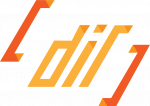

In [ ]:
!pip install qiskit --quiet
!pip install qiskit[visualization] --quiet
!pip install qiskit-aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 96.0 MB/s eta 0:00:00


# **El problema: Hallar el período**

Veamos la función periódica:

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Reminder: Modulo &amp; Modular Arithmetic (Click here to expand)</summary>

La operación módulo (abreviada como 'mod') simplemente significa hallar el residuo al dividir un número entre otro. Por ejemplo:

$$ 17 \bmod 5 = 2 $$

Dado que $17 \div 5 = 3$ con residuo $2$ (es decir, $17 = (3\times 5) + 2$).
Este comportamiento se utiliza en la <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">aritmética modular</a>, donde los números se reinician tras alcanzar un valor determinado (el módulo). Utilizando la aritmética modular, podríamos escribir:

$$ 17 = 2 \bmod 5$$

Observe que aquí $\bmod 5$ se aplica a toda la ecuación (ya que está entre paréntesis), a diferencia de la ecuación anterior, donde solo se aplicaba al lado izquierdo de la ecuación.
</details>

donde $a$ y $N$ son enteros positivos, $a$ es menor que $N$ y no tienen factores comunes. El período, u orden ($r$), es el entero más pequeño (distinto de cero) tal que:

$$a^r \bmod N = 1 $$

Podemos ver un ejemplo de esta función en la gráfica a continuación. Tenga en cuenta que las líneas entre los puntos sirven para ayudar a ver la periodicidad y no representan los valores intermedios entre los marcadores x.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, pi, gcd
import pandas as pd

## **Ejemplo:**

$$f(x)=3^{x}\bmod 35$$

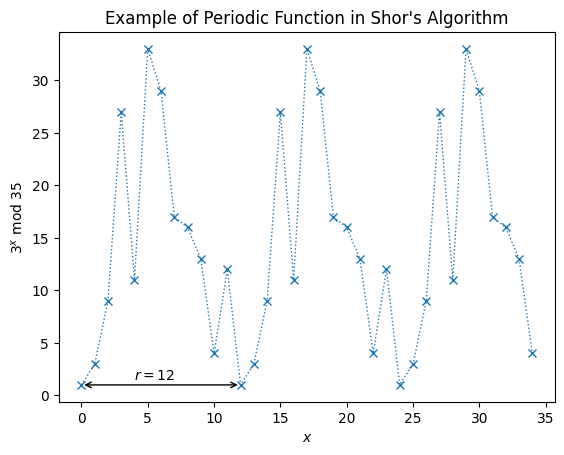

In [ ]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

La solución de Shor fue usar [estimación de fase cuántica](./quantum-phase-estimation.html) en el operador unitario:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

Para ver su utilidad, calculemos cómo podría ser un estado propio de $U$. Si comenzamos en el estado $|1\rangle$, podemos ver que cada aplicación sucesiva de $U$ multiplicará el estado de nuestro registro por $a \pmod N$, y después de $r$ aplicaciones llegaremos de nuevo al estado $|1\rangle$. Por ejemplo, con $a = 3$ y $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle
\end{aligned}$$

# **1. Implementación en Qiskit**

In [ ]:
from qiskit import QuantumCircuit, transpile

from qiskit_aer import Aer  # Simulador de Qiskit

# Visualización de resultados
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector

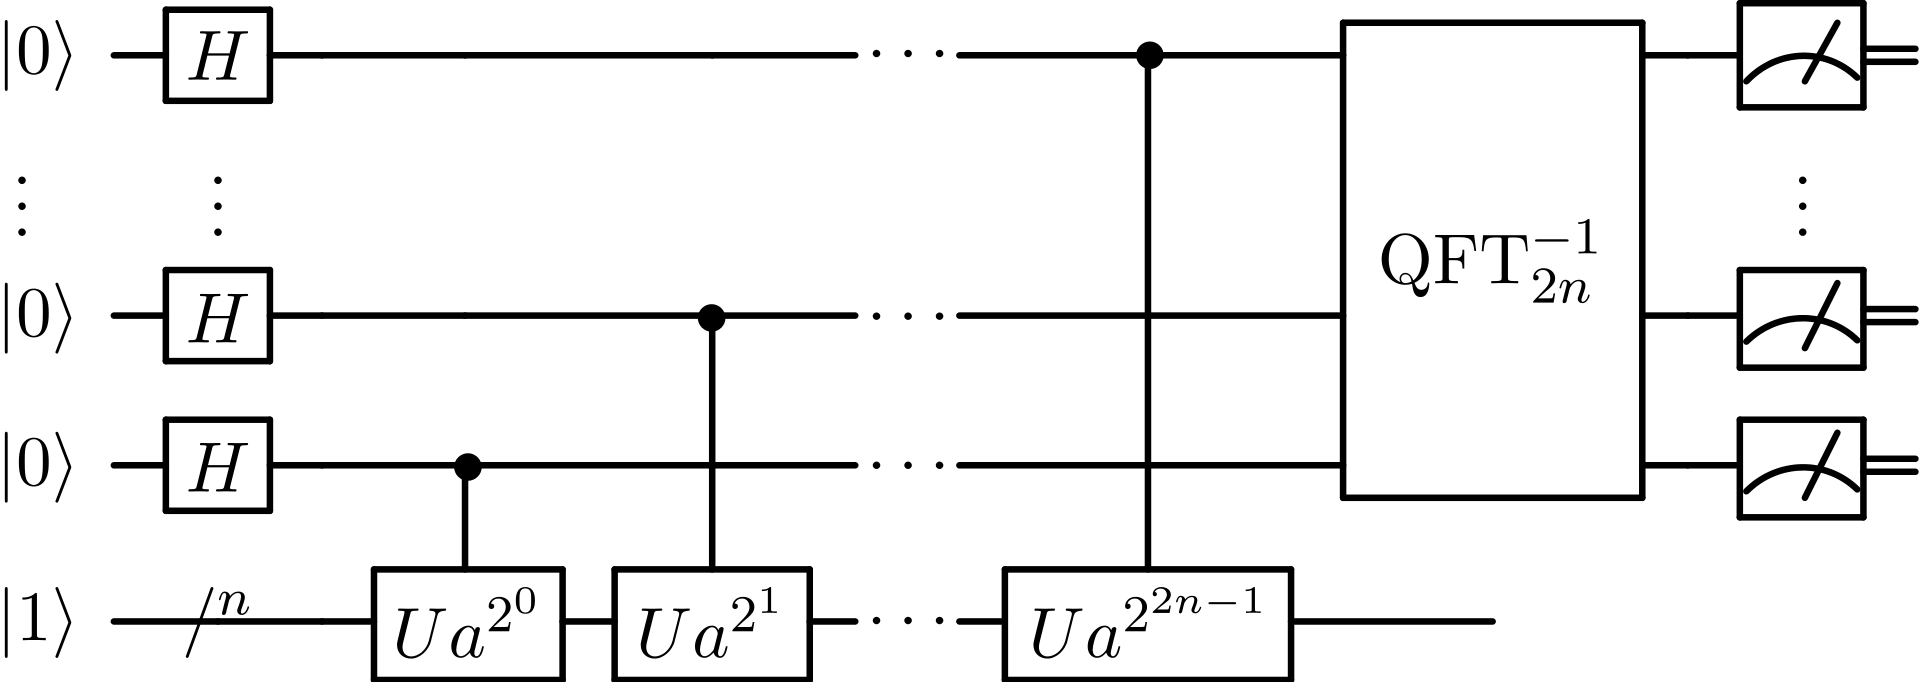

Por lo tanto, una superposición de los estados en este ciclo ($|u_0\rangle$) sería un estado propio de $U$:

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


<details>
    <summary>Click para expandir: Ejemplo con $a = 3$ y $N=35$</summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>


Este estado propio tiene un valor propio de 1, lo cual no resulta muy interesante. Un estado propio más interesante podría ser uno en el que la fase sea diferente para cada uno de estos estados base computacionales. En concreto, veamos el caso en el que la fase del $k^\text{th}$ estado es proporcional a $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle
\end{aligned}
$$

<details>
    <summary>Click para expandir: Ejemplo con $a = 3$ y $N=35$</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(Podemos ver que $r = 12$ aparece en el denominador de la fase).
</details>

Este es un valor propio particularmente interesante, ya que contiene $r$. De hecho, $r$ debe incluirse para garantizar que las diferencias de fase entre los $r$ estados de la base computacional sean iguales. Este no es el único autoestado con este comportamiento; para generalizarlo aún más, podemos multiplicar un entero, $s$, por esta diferencia de fase, que aparecerá en nuestro autovalor:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle
\end{aligned}
$$

<details>
    <summary>Click para expandir: Ejemplo con $a = 3$ y $N=35$</summary>

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$

</details>

Ahora tenemos un estado propio único para cada valor entero de $s$ donde $0 \leq s \leq r-1$. Muy convenientemente, si sumamos todos estos estados propios, las diferentes fases cancelan todos los estados base computacionales excepto $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
    <summary>Click para expandir: Ejemplo con $a = 7$ y $N=15$</summary>

Para ello, analizaremos un ejemplo más pequeño donde $a = 7$ y $N = 15$. En este caso, $r = 4$:

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

Dado que el estado base computacional $|1\rangle$ es una superposición de estos estados propios, lo que significa que si hacemos QPE en $U$ usando el estado $|1\rangle$, mediremos una fase:

$$\phi = \frac{s}{r}$$

Donde $s$ es un entero aleatorio entre $0$ y $r-1$. Finalmente, utilizamos el algoritmo de [fracciones continuas](https://en.wikipedia.org/wiki/Continued_fraction)  en $\phi$ para hallar $r$.

----

## **Ejemplo:**

$$f(x)=7^{x}\bmod 15$$

En este ejemplo, resolveremos el problema de la determinación del período para $a=7$ y $N=15$. Aplicaremos $U$ de tal forma que:

$$U|y\rangle = |ay\bmod 15\rangle $$

Para crear $U^x$, simplemente repetiremos el circuito $x$ veces. En la siguiente sección, analizaremos un método general para crear estos circuitos de manera eficiente. La función `c_amod15` devuelve la puerta U controlada para `a`, repetida `power` veces.

In [ ]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

También importamos el circuito para la QFT (puedes leer más sobre la QFT en el [capítulo de la transformada cuántica de Fourier](./quantum-fourier-transform.html#generalqft)):

In [ ]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Con estos bloques de código podemos construir fácilmente el circuito para el algoritmo de Shor:

# **2. Inicialización del Circuito**

* Queremos evaluar la función $f(x)=a^x \bmod N$ para muchos valores de $x$ en paralelo.

* Al aplicar Hadamard a los qubits de entrada, creamos superposición de todos los valores de $x$, lo que permite evaluar $f(x)$ cuánticamente en paralelo.

Para la inicialización utilizaremos $n=8$ qubits

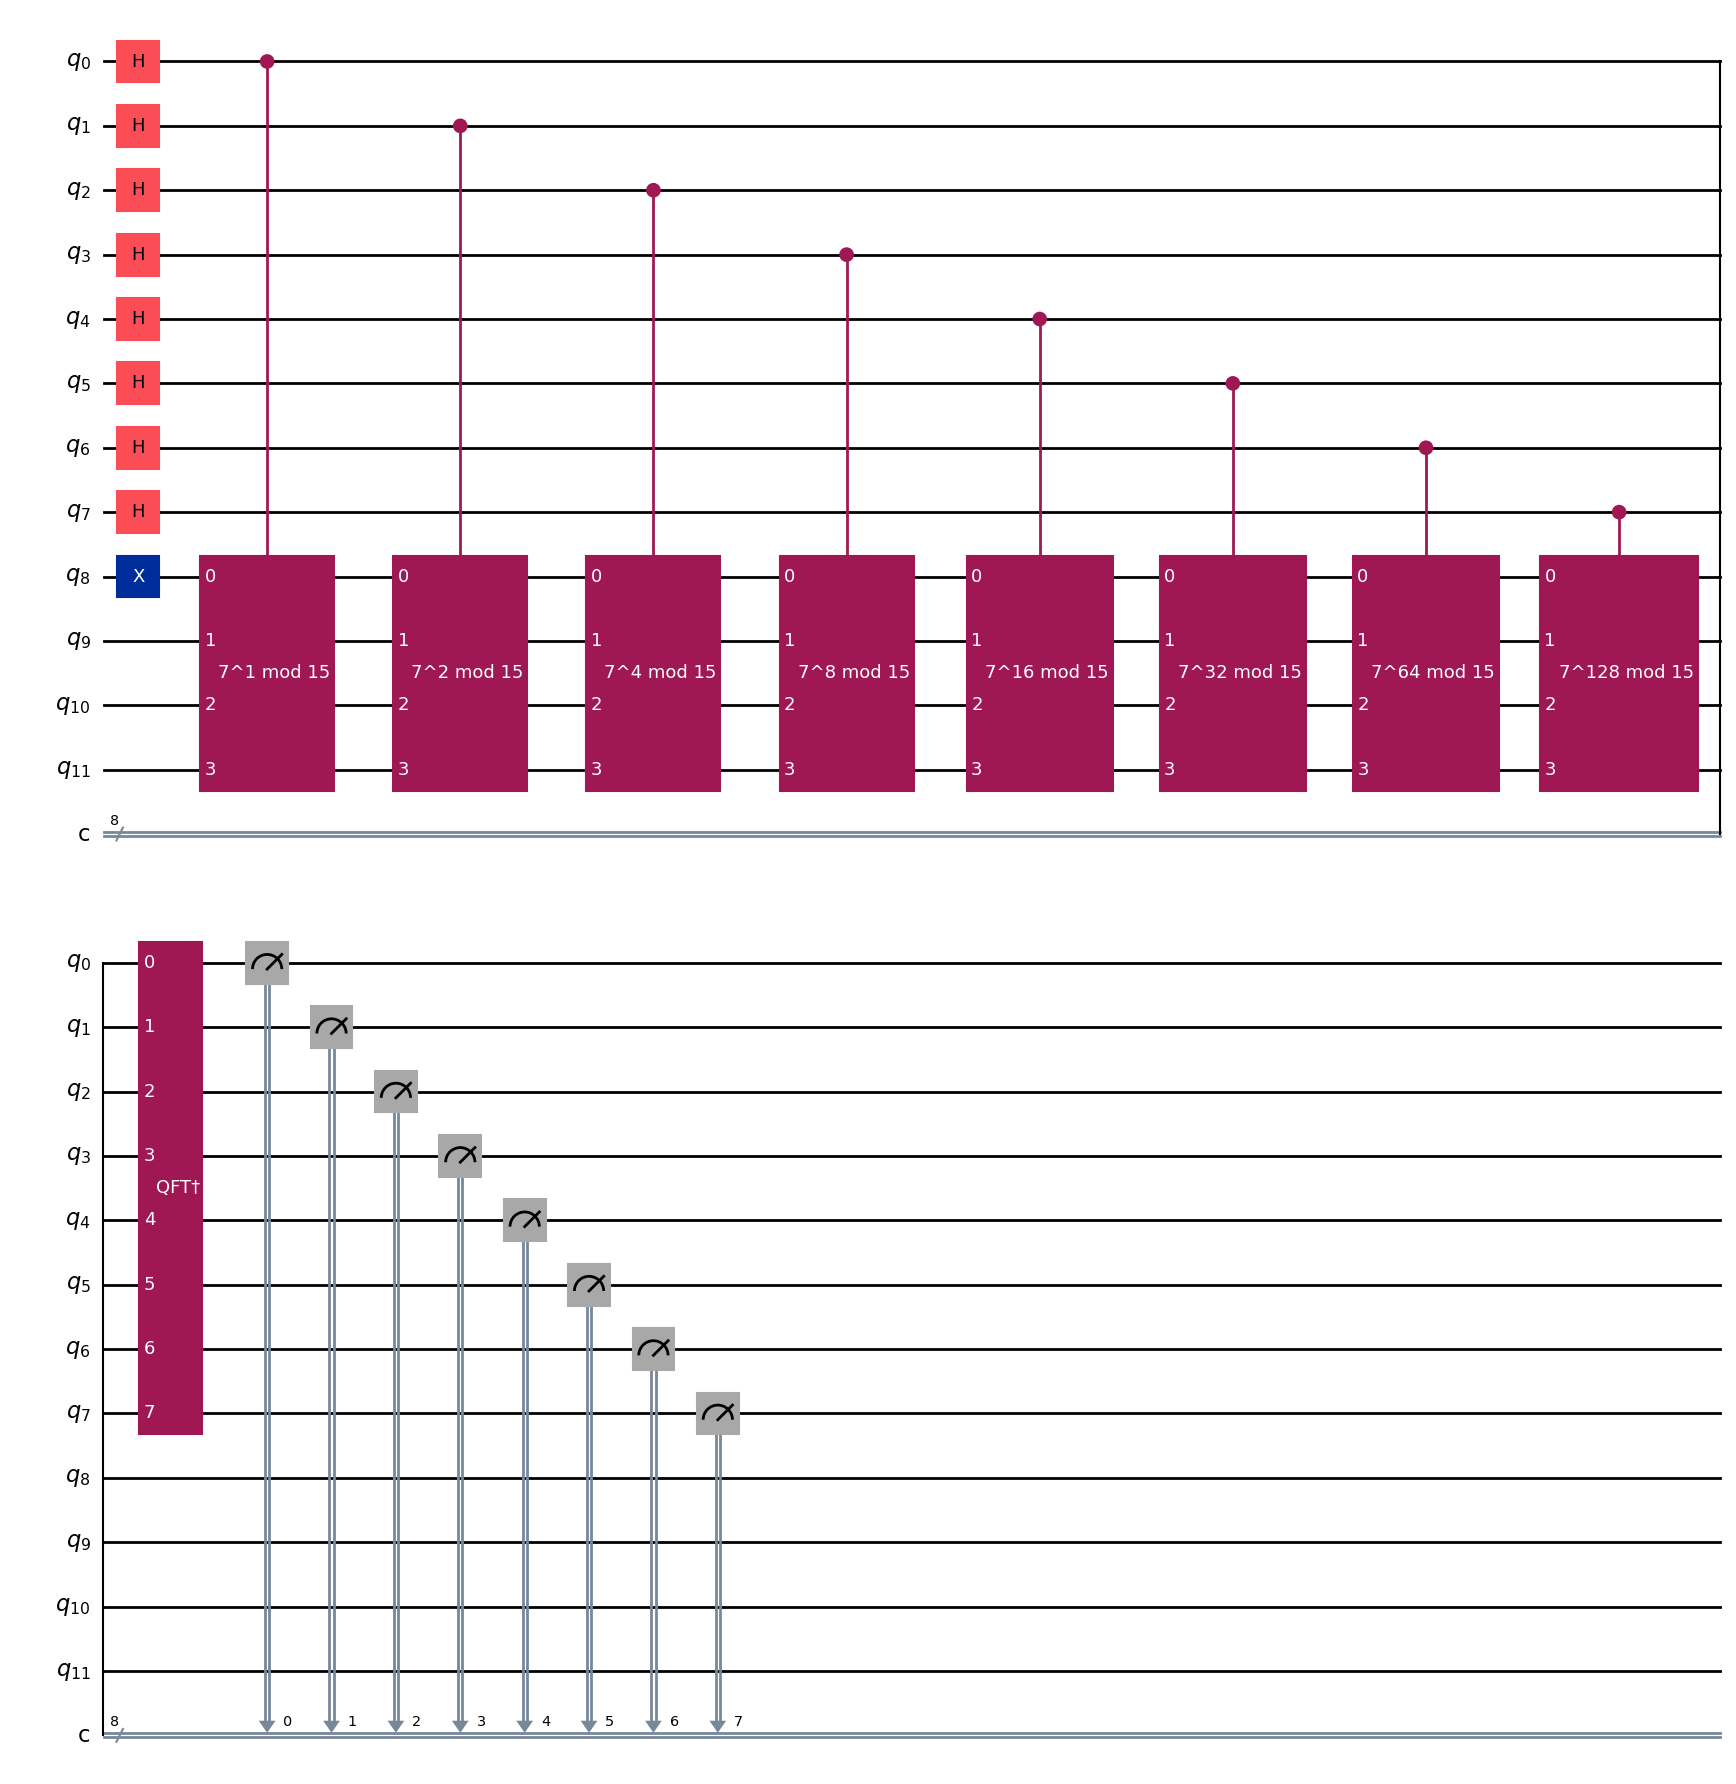

In [ ]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))

qc.draw('mpl')

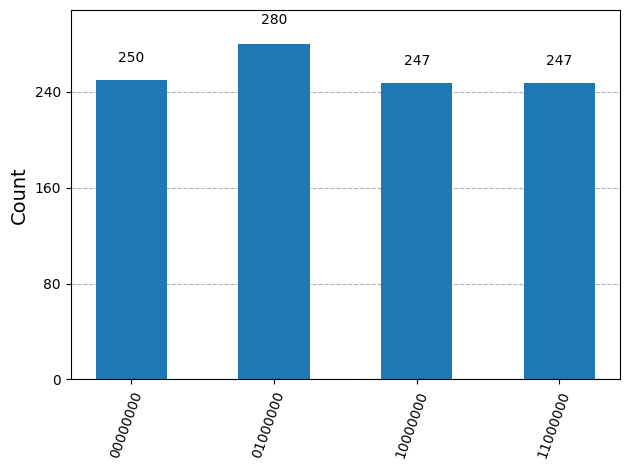

In [ ]:
# Histogram
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

Como tenemos $n=8$ qubits, estos resultados corresponden a las fases medidas de:

In [ ]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  10000000(bin) = 128(dec)  128/256 = 0.50
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


Ahora podemos usar el algoritmo de fracciones continuas para intentar hallar $s$ y $r$. Python tiene esta funcionalidad integrada: podemos usar el módulo `fractions` para convertir un objeto float en un objeto `Fraction`, por ejemplo:

In [ ]:
from fractions import Fraction

Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Dado que esto genera fracciones que devuelven el resultado exacto (en este caso, `0.6660000...`), puede generar resultados complejos como el anterior. Podemos usar el método `.limit_denominator()` para obtener la fracción que más se asemeje a nuestro número flotante, con un denominador inferior a un valor determinado:

In [ ]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

¡Mucho mejor! El orden ($r$) debe ser menor que $N$, así que estableceremos el denominador máximo en `15`:

In [ ]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.50      1/2            2
2   0.25      1/4            4
3   0.00      0/1            1


Podemos ver que dos de los valores propios medidos nos dieron el resultado correcto: $r=4$, y que el algoritmo de Shor tiene probabilidades de fallar. Estos resultados incorrectos se deben a que $s = 0$, o a que $s$ y $r$ no son coprimos y, en lugar de $r$, se nos da un factor de $r$. La solución más sencilla es simplemente repetir el experimento hasta obtener un resultado satisfactorio para $r$.

* En el algoritmo de Shor, la función que evaluamos es $f(x)=a^x \bmod N$, que tiene un período $r$.

* Estas funciones sirven como ejemplos de cómo implementar
$f(x)$ en un circuito cuántico.

# **3. Función Modular**



In [ ]:
def _7mod15():

    circ = QuantumCircuit(8)
    circ.x(4)
    circ.cx(0,5)
    circ.cx(0,6)
    circ.cx(1,4)
    circ.cx(1,6)
    for i in range(4,8):
        circ.ccx(0,1,i)
    gate = circ.to_gate()
    gate.name = "7^x mod 15"
    return gate

Este bloque implementa la función modular $f(x)=7^x \bmod 15$, que es una parte fundamental del algoritmo de Shor. Su propósito es codificar en los qubits de salida los valores correspondientes a esta función para diferentes valores de $x$.

Este bloque inicializa un circuito cuántico con:

* 4 qubits de entrada para almacenar el valor de $x$.

* 4 qubits de función para almacenar el resultado de $f(x)=7^x \bmod 15$.

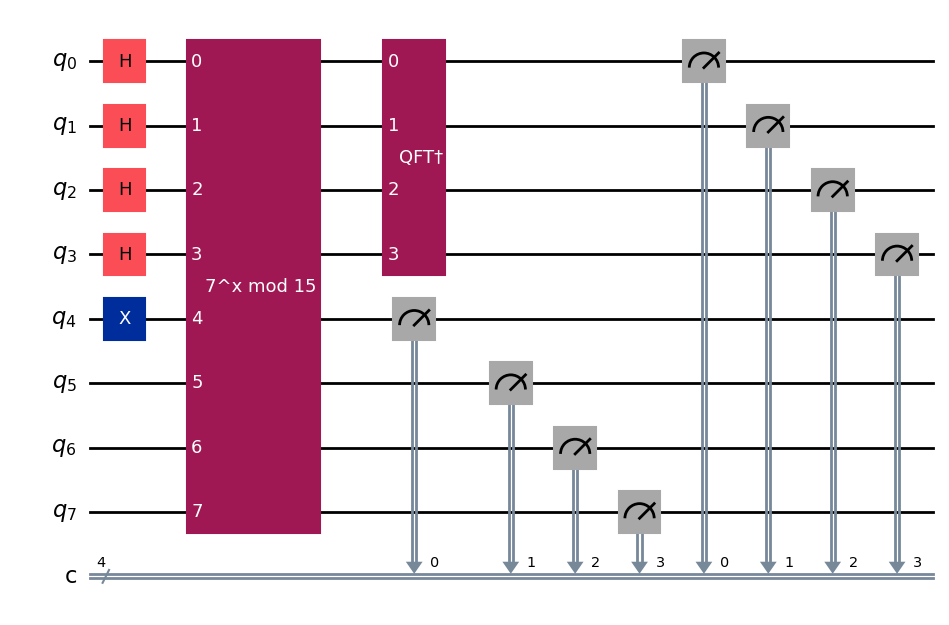

In [ ]:
circ = QuantumCircuit(8, 4)
circ.h(range(4))
circ.x(4)
circ.append(_7mod15(), range(8))
circ.measure(range(4,8), range(4))
circ.append(qft_dagger(4), range(4))
circ.measure(range(4), range(4))
circ.draw('mpl')

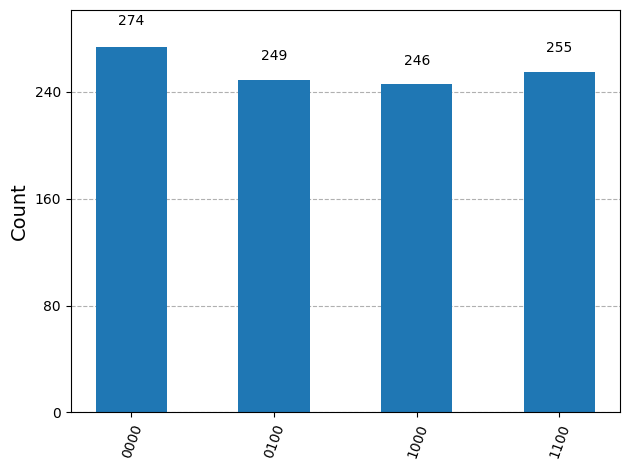

In [ ]:
# Histogram
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(circ, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [ ]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**4)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**4} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

        Register Output         Phase
0  0000(bin) =   0(dec)   0/16 = 0.00
1  0100(bin) =   4(dec)   4/16 = 0.25
2  1100(bin) =  12(dec)  12/16 = 0.75
3  1000(bin) =   8(dec)   8/16 = 0.50


In [ ]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.75      3/4            4
3   0.50      1/2            2


In [ ]:
# con esto sabemos que 4 es raiz cuadrada ya que el mcd de 4 8 12 es 4
# sabiendo esto podemos calcular los factores primos de la siguiente manera:
import math

primer_factor = math.gcd(4-1, 15)
segundo_factor = math.gcd(4+1, 15)
print("factores primos:", primer_factor, segundo_factor)

factores primos: 3 5
